In [1]:
import re
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import colorcet as cc
import squarify
import os

In [2]:
df = pd.read_csv('../data/df_umap.csv')

In [3]:
## get annotation according to UniProt:

file_UNP = '../data/uniprot_Mtb.tab'
df_UNP = pd.read_csv(file_UNP, sep='\t')
df_UNP = df_UNP[['Entry', 'Gene names']]

file_UNP_2 = '../data/UP000001584.csv'
df_UNP_2 = pd.read_csv(file_UNP_2, sep='\t')
df_UNP_2 = df_UNP_2[['Entry', 'Annotation']]
df_UNP = df_UNP.merge(df_UNP_2, how = 'inner', on = 'Entry')

rvid = [re.findall('Rv\d\d\d\d[a-zA-Z]?', gn)[0] for gn in df_UNP['Gene names']]
df_UNP['Rv_ID'] = rvid
df_UNP = df_UNP[['Entry', 'Rv_ID', 'Annotation']]
df_UNP['Annotation'] = [int(a.strip()[0]) for a in df_UNP.Annotation]

df_w_annot = df.merge(df_UNP, how = 'inner', on = 'Rv_ID')

df_w_annot['Gene name'].fillna('', inplace=True)

## Show the genes in the CRISPRi library:

file_crispri = '../data/cloned_genes.xlsx'
df_crispri = pd.read_excel(file_crispri)
df_crispri.rename(columns = {'gene\nname':'gene_name'}, inplace=True)
df_crispri['gene_name'].fillna('', inplace=True)

df_crispri = df_crispri[df_crispri.gene_name.str.contains('Rv')].copy()
df_crispri = df_crispri[df_crispri.ID.values<=74].copy()

df_crispri['Rv_ID'] = [''.join(gn.split('_')) for gn in df_crispri.gene_name]
df_crispri = df_crispri[['ID', 'Rv_ID']]
df_crispri.reset_index(inplace=True, drop=True)

df_w_annot['CRISPRi'] = df_w_annot.Rv_ID.isin(df_crispri.Rv_ID)

# Filter outliers
df_w_annot_ = df_w_annot[(df_w_annot['u1'].values < 6) & (df_w_annot['u2'].values < 5)]

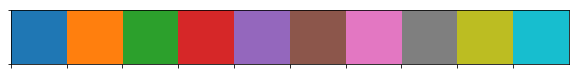

In [4]:
cols = sns.color_palette()
sns.palplot(cols)

### Simple vanilla UMAP:

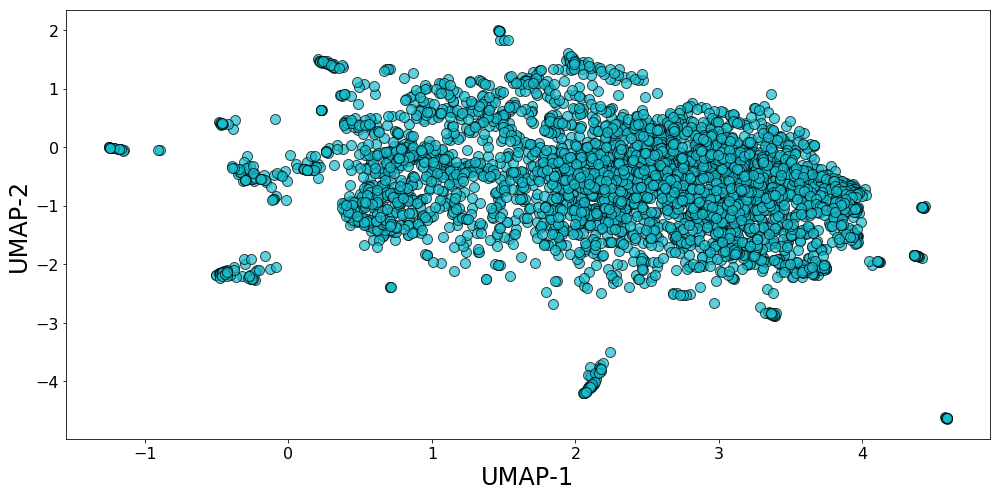

In [28]:
plt.figure(figsize=(14,7))

plt.scatter(df_w_annot_.u1, df_w_annot_.u2, s = 100, color = cols[-1], edgecolors='k', alpha = 0.7)

plt.xlabel('UMAP-1', fontsize = 24 )
plt.ylabel('UMAP-2', fontsize = 24 )
xt = plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)

plt.tight_layout()
fig_file = '../figures/umap_vanilla.png'
plt.savefig(fig_file, dpi = 300)

### UMAP with neighborhood:

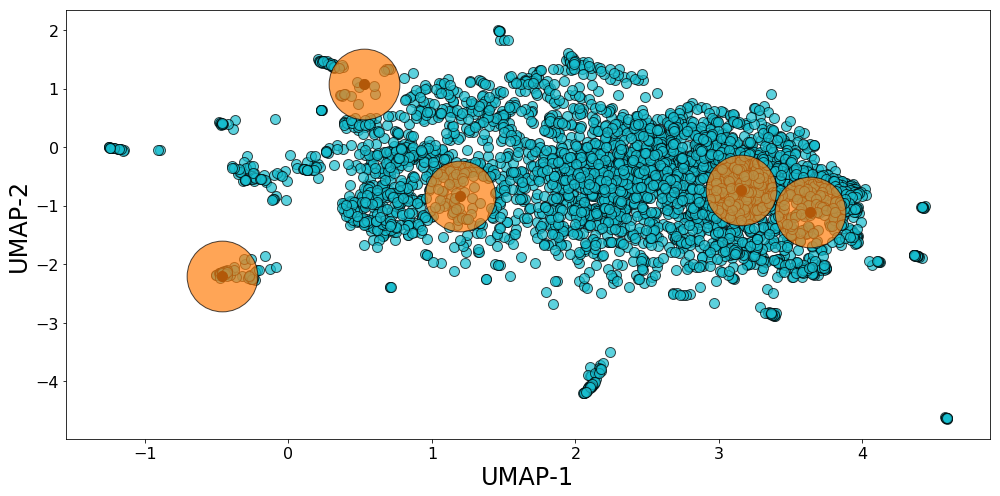

In [30]:
plt.figure(figsize=(14,7))

plt.scatter(df_w_annot_.u1, df_w_annot_.u2, s = 100, color = cols[-1], edgecolors='k', alpha = 0.7)

for i in range(5):
    df_rv_rand = df_w_annot_.sample()
    plt.scatter(df_rv_rand.u1, df_rv_rand.u2, s = 100, color = 'k', edgecolors='k', alpha = 1)
    plt.scatter(df_rv_rand.u1, df_rv_rand.u2, s = 5000, color = cols[1], edgecolors='k', alpha = 0.7)

plt.xlabel('UMAP-1', fontsize = 24 )
plt.ylabel('UMAP-2', fontsize = 24 )
xt = plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)

plt.tight_layout()
fig_file = '../figures/umap_rand_neighborhoods.png'
plt.savefig(fig_file, dpi = 300)

### CRISPRi's with neighborhood: 

In [41]:
df_CRISPRi = df_w_annot_[df_w_annot_.CRISPRi.values == True].copy()
df_CRISPRi.shape

(59, 21)

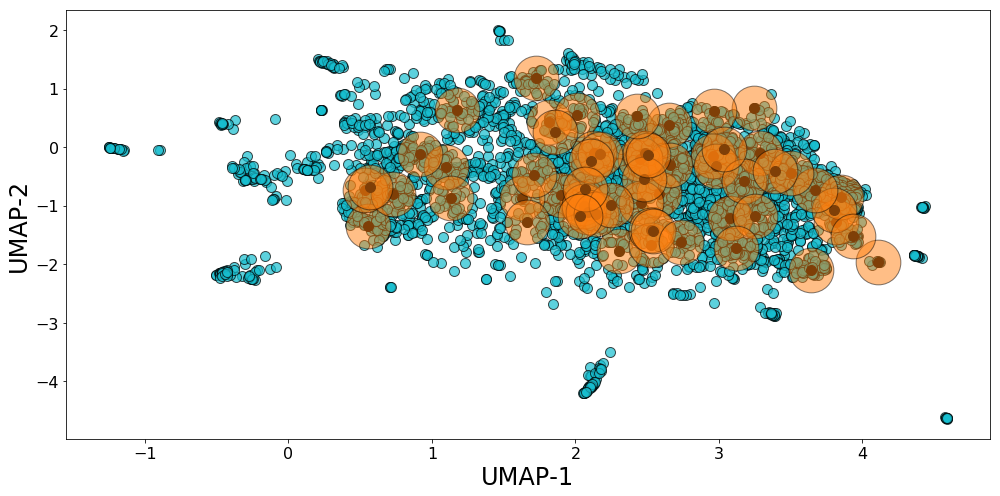

In [38]:
plt.figure(figsize=(14,7))

plt.scatter(df_w_annot_.u1, df_w_annot_.u2, s = 100, color = cols[-1], edgecolors='k', alpha = 0.7)

for index, row in df_CRISPRi.iterrows():
    plt.scatter(row['u1'], row['u2'], s = 100, color = 'k', edgecolors='k', alpha = 1)
    plt.scatter(row['u1'], row['u2'], s = 2000, color = cols[1], edgecolors='k', alpha = 0.5)

plt.xlabel('UMAP-1', fontsize = 24 )
plt.ylabel('UMAP-2', fontsize = 24 )
xt = plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)

plt.tight_layout()
fig_file = '../figures/umap_CRISPRi_neighborhoods.png'
plt.savefig(fig_file, dpi = 300)

### Single gene neighborhood:

In [48]:
df_w_annot_[df_w_annot_['Gene name'].str.contains('aro')]

,Rv_ID,Gene name,Geneid/Contrast_id,is_sdr,func_tuberculist,function_sanger,redox_enzyme,function_redox_,Function,groups,...,cog_annot,UK_score_4,u1,u2,u3,u1_tn,u2_tn,Entry,Annotation,CRISPRi
2210,Rv2178c,aroG,2226.0,0.0,intermediary metabolism and respiration,DAHP synthase,0.0,NaN,2-keto-3-deoxy-D-arabino-heptulosonate-7-phosp...,0.0,...,Amino acid transport and metabolism,0.0,1.959477,-1.823739,-0.334434,-8.275676,2.013262,O53512,5,False
2578,Rv2537c,aroD,2602.0,0.0,intermediary metabolism and respiration,3-dehydroquinate dehydratase,0.0,NaN,3-dehydroquinate dehydratase II (EC 4.2.1.10),0.0,...,Amino acid transport and metabolism,0.0,2.296678,-0.436287,0.954049,11.858851,-6.159035,P9WPX7,5,False
2579,Rv2538c,aroB,2603.0,0.0,intermediary metabolism and respiration,3-dehydroquinate synthase,0.0,NaN,3-dehydroquinate synthase (EC 4.2.3.4),0.0,...,Amino acid transport and metabolism,0.0,1.449201,0.499308,0.018240,-8.130288,0.121441,P9WPX9,5,False
2580,Rv2539c,aroK,2604.0,0.0,intermediary metabolism and respiration,shikimate kinase I,0.0,NaN,Shikimate kinase I (EC 2.7.1.71),0.0,...,Amino acid transport and metabolism,0.0,1.913317,-1.430882,0.499135,-7.979780,0.018720,P9WPY3,5,False
2581,Rv2540c,aroF,2605.0,0.0,intermediary metabolism and respiration,chorismate synthase,0.0,NaN,Chorismate synthase (EC 4.2.3.5),0.0,...,Amino acid transport and metabolism,0.0,1.383942,0.513182,-0.090678,9.651406,-1.613326,P9WPY1,5,False
2594,Rv2552c,aroE,2618.0,0.0,intermediary metabolism and respiration,shikimate 5-dehydrogenase,1.0,Possibly involved at the fourth step in the bi...,Shikimate 5-dehydrogenase I alpha (EC 1.1.1.25),0.0,...,Amino acid transport and metabolism,0.0,1.125293,-0.402689,0.321998,-8.066381,0.064079,I6Y120,2,False
3274,Rv3227,aroA,3312.0,0.0,intermediary metabolism and respiration,3-phosphoshikimate 1-carboxyvinyl transferase,0.0,NaN,5-Enolpyruvylshikimate-3-phosphate synthase (E...,0.0,...,Amino acid transport and metabolism,0.0,2.275230,-1.189012,1.524705,-4.873866,4.628697,P9WPY5,5,False


In [59]:
df = df_w_annot_[df_w_annot_.Rv_ID.values == 'Rv1307'].copy()

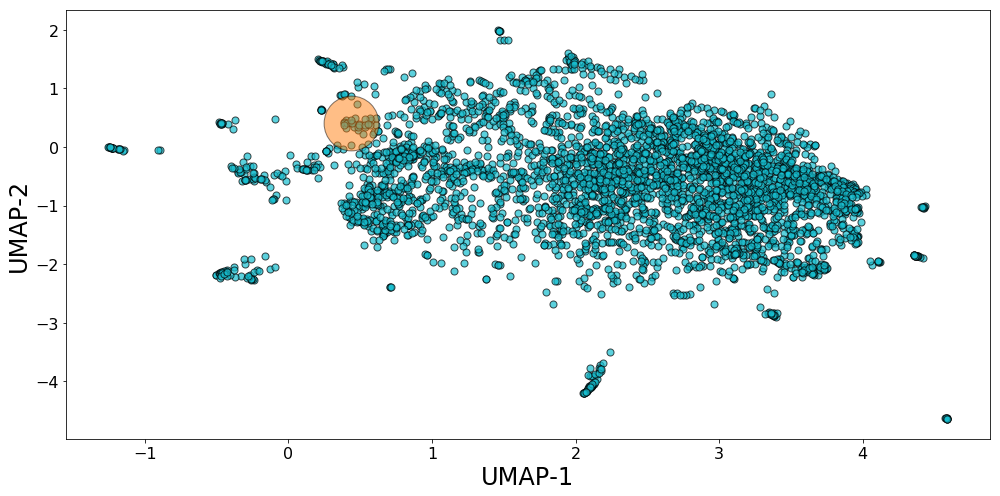

In [60]:
plt.figure(figsize=(14,7))

plt.scatter(df_w_annot_.u1, df_w_annot_.u2, s = 50, color = cols[-1], edgecolors='k', alpha = 0.7)

for index, row in df.iterrows():
#     plt.scatter(row['u1'], row['u2'], s10= 100, color = 'k', edgecolors='k', alpha = 1)
    plt.scatter(row['u1'], row['u2'], s = 3000, color = cols[1], edgecolors='k', alpha = 0.5)

plt.xlabel('UMAP-1', fontsize = 24 )
plt.ylabel('UMAP-2', fontsize = 24 )
xt = plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)

# plt.xlim(0, 4.5)
# plt.ylim(-3,0)

plt.tight_layout()
fig_file = '../figures/umap_onegene_neighborhood_v2.png'
plt.savefig(fig_file, dpi = 250)

### CRISPRi RNA vs. TnSeq

In [61]:
file_in = '../data/CRISPRi_NN_analysis.csv'
df_num_common_mean = pd.read_csv(file_in)
df_num_common_mean.rename(columns={'query':'Rv_ID'}, inplace=True)

In [50]:
df_CRISPRi_2 = df_CRISPRi.merge(df_num_common_mean, how = 'inner', on = 'Rv_ID')

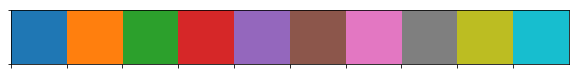

In [53]:
sns.palplot(cols)

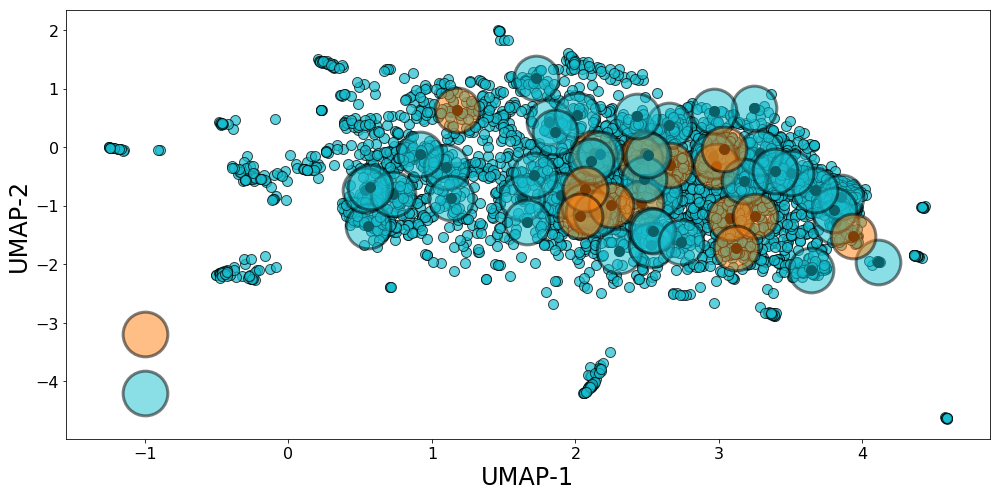

In [76]:
plt.figure(figsize=(14,7))

plt.scatter(df_w_annot_.u1, df_w_annot_.u2, s = 100, color = cols[-1], edgecolors='k', alpha = 0.7)

for index, row in df_CRISPRi_2.iterrows():
    plt.scatter(row['u1'], row['u2'], s = 100, color = 'k', edgecolors='k', alpha = 1)
    if row['num_common_tnseq_mean'] >= 0.20:
        plt.scatter(row['u1'], row['u2'], s = 2000, color = cols[1], edgecolors='k', linewidths=3, alpha = 0.5)
    else:
        plt.scatter(row['u1'], row['u2'], s = 2000, color = cols[-1], edgecolors='k', linewidths=3, alpha = 0.5)

plt.scatter(-1, -3.2, s = 2000, color = cols[1], edgecolors='k', linewidths=3, alpha = 0.5)
plt.scatter(-1, -4.2, s = 2000, color = cols[-1], edgecolors='k', linewidths=3, alpha = 0.5)

plt.xlabel('UMAP-1', fontsize = 24 )
plt.ylabel('UMAP-2', fontsize = 24 )
xt = plt.xticks(fontsize = 16)
yt = plt.yticks(fontsize = 16)

plt.tight_layout()
fig_file = '../figures/umap_CRISPRi_neighbors_RNAvsTnSeq.png'
plt.savefig(fig_file, dpi = 300)

### Annotations distribution:

In [33]:
df_w_annot_.Annotation.value_counts()

1    2039
2     723
3     527
5     383
4     301
Name: Annotation, dtype: int64

In [22]:
annotation_counts = df_w_annot_.Annotation.value_counts().tolist()
label=["1 out of 5", "2 out of 5", "3 out of 5", "4 out of 5", "5 out of 5"]
colors = cols[:5]

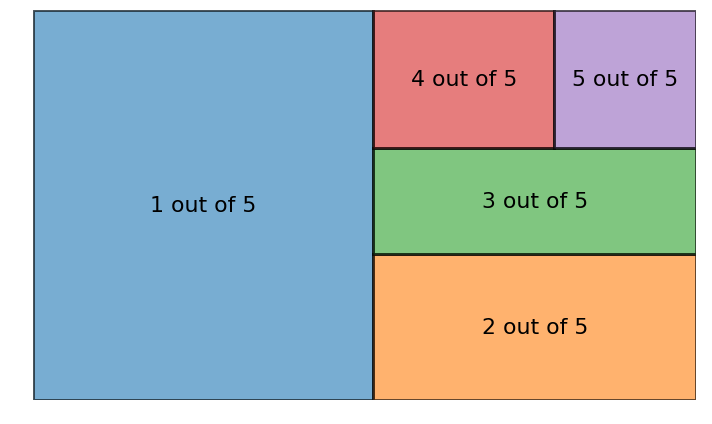

In [30]:
plt.figure(figsize=(10,6))
squarify.plot(annotation_counts, label=label, alpha=0.6, 
              text_kwargs={'fontsize':22}, color=colors, edgecolor="k", linewidth=3)
tt = plt.axis('off')
plt.tight_layout()
fig_name = '../figures/UniProt_annotations.png'
plt.savefig(fig_name, dpi = 300)

### Same, for other proteomes: 

In [37]:
path = '/Users/ajinich/Dropbox (Personal)/KyuRhee/unknown_function/unknown_redox/data/other_proteomes/reference_proteomes'
list_files = [ os.path.join(path, f) for f in os.listdir(path) ]

In [3]:
from random import sample

In [81]:
list_rand = sample(list_files, 30)

In [82]:
list_rand[0] = os.path.join(path, 'UP000000625.csv')
list_rand[1] = os.path.join(path, 'UP000001584.csv')
list_rand[2] = os.path.join(path, 'UP000001570.csv')
list_rand[3] = os.path.join(path, 'UP000001973.csv')
list_rand[4] = os.path.join(path, 'UP000002438.csv')
list_rand[5] = os.path.join(path, 'UP000000429.csv')

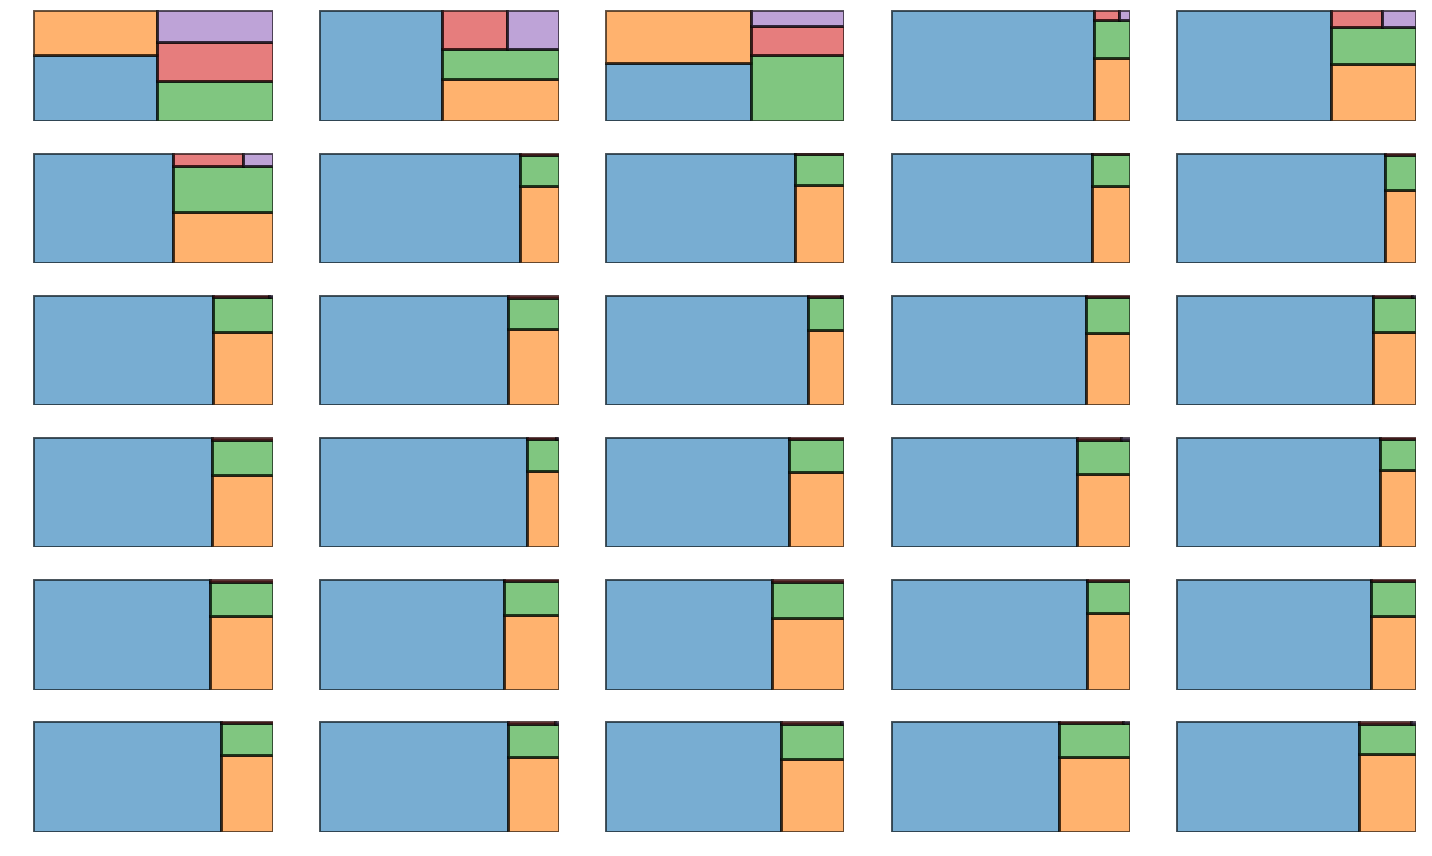

In [83]:
counter = 1
plt.figure(figsize=(20,12))

for file in list_rand:
    name = file.split('/')[-1].split('.')[0]
    df = pd.read_csv(file, sep='\t')
    annotation_counts = df.Annotation.value_counts().tolist()
    # label=["1 out of 5", "2 out of 5", "3 out of 5", "4 out of 5", "5 out of 5"]
    colors = cols[:5]
    plt.subplot(6, 5, counter)
    squarify.plot(annotation_counts, alpha=0.6, 
                  text_kwargs={'fontsize':12}, color=colors, edgecolor="k", linewidth=3)
    tt = plt.axis('off')
    counter += 1

plt.tight_layout()
fig_name = '../figures/UniProt_annotations_many_30.png'
plt.savefig(fig_name, dpi = 300)


### Human (for Carl Nathan)

In [4]:
file = '../data/uniprot-proteome_UP000005640.tab'
df = pd.read_csv(file, sep = '\t')

In [17]:
df.shape

(75069, 8)

In [12]:
annotation_counts = df.Annotation.value_counts().tolist()
label=["1 out of 5", "2 out of 5", "3 out of 5", "4 out of 5", "5 out of 5"]
colors = cols[:5]

In [19]:
annotation_counts[-1]/sum(annotation_counts)

0.029825893511302933

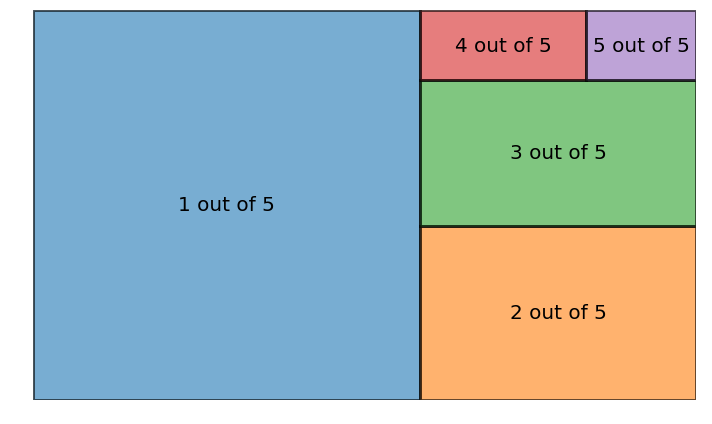

In [13]:
plt.figure(figsize=(10,6))
squarify.plot(annotation_counts, label=label, alpha=0.6, 
              text_kwargs={'fontsize':20}, color=colors, edgecolor="k", linewidth=3)
tt = plt.axis('off')
plt.tight_layout()
fig_name = '../figures/UniProt_annotations_Human.png'
plt.savefig(fig_name, dpi = 300)